# PA Quantum Neuron

Build a classical neuron with a quantum circuit

In [1]:
from colorama import Fore, Back, Style 

import numpy as numpy
from pennylane import numpy as np
import pennylane as qml
from pennylane.optimize import NesterovMomentumOptimizer
from pennylane.math import requires_grad

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

from math import pi


# Quantum

In [2]:
max_iterations = 200
loop_count = 13

In [3]:

dev_1 = qml.device('default.qubit', wires=2)
dev_2 = qml.device('default.qubit', wires=2)
dev_3 = qml.device('default.qubit', wires=2)

## Classifier 1
init_weights_1 = (0.01 * np.random.randn(6*3), 0.0)

@qml.qnode(dev_1)
def circuit_1(weights, data):
    qml.Hadamard(0)
    qml.Hadamard(1)
    
    # layer 1
    qml.RY(data[0], wires=0) # input feature 1
    qml.RY(data[1], wires=1) # input feature 2
    
    qml.CNOT(wires=[0, 1])

    qml.Rot(weights[0], weights[1], weights[2], wires=0)
    qml.Rot(weights[3], weights[4], weights[5], wires=1)
    
    qml.CNOT(wires=[0, 1])

    # layer 2
    qml.RY(data[0], wires=0) # input feature 1
    qml.RY(data[1], wires=1) # input feature 2
    
    qml.CNOT(wires=[0, 1])

    qml.Rot(weights[6], weights[7], weights[8], wires=0)
    qml.Rot(weights[9], weights[10], weights[11], wires=1)
    
    qml.CNOT(wires=[0, 1])

    # layer 3
    qml.RY(data[0], wires=0) # input feature 1
    qml.RY(data[1], wires=1) # input feature 2
    
    qml.CNOT(wires=[0, 1])

    qml.Rot(weights[12], weights[13], weights[14], wires=0)
    qml.Rot(weights[15], weights[16], weights[17], wires=1)
    
    qml.CNOT(wires=[0, 1])
    
    return qml.expval(qml.PauliZ(0))

def vc_classifier_1(var, data):
    weights = var[0]
    bias = var[1]
    return circuit_1(weights, data) + bias


## Classifier 2
init_weights_2 = (0.01 * np.random.randn(6*3), 0.0)

@qml.qnode(dev_2)
def circuit_2(weights, data):
    qml.Hadamard(0)
    qml.Hadamard(1)
    
    # layer 1
    qml.RY(data[0], wires=0) # input feature 1
    qml.RX(data[1], wires=0) # input feature 2
    
    qml.CNOT(wires=[0, 1])
    
    qml.Rot(weights[0], weights[1], weights[2], wires=0)
    qml.Rot(weights[3], weights[4], weights[5], wires=1)
    
    qml.CNOT(wires=[0, 1])
    
    # layer 2
    qml.RY(data[0], wires=0) # input feature 1
    qml.RX(data[1], wires=0) # input feature 2
    
    qml.CNOT(wires=[0, 1])
    
    qml.Rot(weights[6], weights[7], weights[8], wires=0)
    qml.Rot(weights[9], weights[10], weights[11], wires=1)
    
    qml.CNOT(wires=[0, 1])
    
    # layer 3
    qml.RY(data[0], wires=0) # input feature 1
    qml.RX(data[1], wires=0) # input feature 2
    
    qml.CNOT(wires=[0, 1])
    
    qml.Rot(weights[12], weights[13], weights[14], wires=0)
    qml.Rot(weights[15], weights[16], weights[17], wires=1)
    
    qml.CNOT(wires=[0, 1])


    return qml.expval(qml.PauliZ(0))

def vc_classifier_2(var, data):
    weights = var[0]
    bias = var[1]
    return circuit_2(weights, data) + bias
  

## Classifier 3
init_weights_3 = (0.01 * np.random.randn(6*3), 0.0)

@qml.qnode(dev_3)
def circuit_3(weights, data):
    qml.Hadamard(0)
    qml.Hadamard(1)
    
    # layer 1
    qml.RY(data[0], wires=0) # input feature 1
    qml.RX(data[1], wires=1) # input feature 2
    
    qml.CNOT(wires=[0, 1])
    
    qml.Rot(weights[0], weights[1], weights[2], wires=0)
    qml.Rot(weights[3], weights[4], weights[5], wires=1)
    
    qml.CNOT(wires=[0, 1])
    
    # layer 2
    qml.RY(data[0], wires=0) # input feature 1
    qml.RX(data[1], wires=1) # input feature 2
    
    qml.CNOT(wires=[0, 1])
    
    qml.Rot(weights[6], weights[7], weights[8], wires=0)
    qml.Rot(weights[9], weights[10], weights[11], wires=1)
    
    qml.CNOT(wires=[0, 1])
    
    # layer 3
    qml.RY(data[0], wires=0) # input feature 1
    qml.RX(data[1], wires=1) # input feature 2
    
    qml.CNOT(wires=[0, 1])
    
    qml.Rot(weights[12], weights[13], weights[14], wires=0)
    qml.Rot(weights[15], weights[16], weights[17], wires=1)
    
    qml.CNOT(wires=[0, 1])
    
    return qml.expval(qml.PauliZ(0))

def vc_classifier_3(var, data):
    weights = var[0]
    bias = var[1]
    return circuit_3(weights, data) + bias


## generic
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(labels)
    return loss

def cost(vc_classifier, weights, datas, labels):
    predictions = [vc_classifier(weights, f) for f in datas]
    return square_loss(labels, predictions)

def accuracy(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)
    return loss
  
def plot_costs(costs, num_layers):
  # plot costs
   fig, (ax1) = plt.subplots(1)
   fig.suptitle('Costs')
   ax1.plot(range(len(costs)), costs, label='Layers: {}'.format(num_layers))
   ax1.set_xlabel('iteration number')
   ax1.set_ylabel('cost objective function')
   ax1.legend(loc="upper right")
   plt.show()

# init weights
# var_init = (0.01 * np.random.randn(1, 2, 3), 0.0)


In [4]:
def vc_quantum(vc_classifier, init_weights, x_train, x_test, X, y_train, y_test, Y):
  opt = NesterovMomentumOptimizer(0.01)
  batch_size = 5
  var = init_weights
  iterations = max_iterations
  costs = np.zeros(iterations) 

  for it in range(iterations):

      # Update the weights by one optimizer step
      batch_index = np.random.randint(0, len(x_train), (batch_size,))
      feats_train_batch = x_train[batch_index]
      Y_train_batch = y_train[batch_index]
      var, stepCost = opt.step_and_cost(lambda v: cost(vc_classifier, v, feats_train_batch, Y_train_batch), var)

      # Compute predictions on train and validation set
      predictions_train = [np.sign(vc_classifier(var, f)) for f in x_train]
      predictions_val = [np.sign(vc_classifier(var, f)) for f in x_test]
      predictions_all = [np.sign(vc_classifier(var, f)) for f in X]

      # Compute accuracy on train and validation set
      acc_train = accuracy(y_train, predictions_train)
      acc_val = accuracy(y_test, predictions_val)
      acc_all = accuracy(Y, predictions_all)

      # gather informations for plotting
      costs[it] = cost(vc_classifier, var, X, Y)

      print(
          "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc val: {:0.7f} | Acc all: {:0.7f} "
          "".format(it + 1, costs[it], acc_train, acc_val, acc_all)
      )
  
  return [var, acc_val]

# plot costs
# plot_costs(costs, 0)

Loop count: 0


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.8772274 | Acc train: 0.7600000 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     2 | Cost: 0.8756868 | Acc train: 0.7600000 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     3 | Cost: 0.8733790 | Acc train: 0.7600000 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     4 | Cost: 0.8717244 | Acc train: 0.7600000 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     5 | Cost: 0.8714586 | Acc train: 0.7600000 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     6 | Cost: 0.8702376 | Acc train: 0.7600000 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     7 | Cost: 0.8643328 | Acc train: 0.7600000 | Acc val: 0.6800000 | Acc all: 0.7300000 
Iter:     8 | Cost: 0.8597421 | Acc train: 0.7600000 | Acc val: 0.6800000 | Acc all: 0.7300000 
Iter:     9 | Cost: 0.8564015 | Acc train: 0.7466667 | Acc val: 0.6800000 | Acc all: 0.7300000 
Iter:    10 | Cost: 0.8542188 | Acc train: 0.7466667 | Acc val: 0.6800000 | Acc all: 0.7300000 
Iter:    11 | Cost: 0.8484468 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.5106401 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     2 | Cost: 1.5085595 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.5007751 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:     4 | Cost: 1.4915052 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.4875014 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:     6 | Cost: 1.4833077 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:     7 | Cost: 1.4801480 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:     8 | Cost: 1.4780324 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:     9 | Cost: 1.4619295 | Acc train: 0.5466667 | Acc val: 0.4800000 | Acc all: 0.5600000 
Iter:    10 | Cost: 1.4449616 | Acc train: 0.5466667 | Acc val: 0.4800000 | Acc all: 0.5500000 
Iter:    11 | Cost: 1.4185039 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2216677 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     2 | Cost: 1.2209486 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     3 | Cost: 1.2205279 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     4 | Cost: 1.2200557 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     5 | Cost: 1.2200084 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     6 | Cost: 1.2213458 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     7 | Cost: 1.2240582 | Acc train: 0.6133333 | Acc val: 0.5600000 | Acc all: 0.5900000 
Iter:     8 | Cost: 1.2260140 | Acc train: 0.6133333 | Acc val: 0.5600000 | Acc all: 0.5900000 
Iter:     9 | Cost: 1.2255314 | Acc train: 0.6266667 | Acc val: 0.5600000 | Acc all: 0.5900000 
Iter:    10 | Cost: 1.2256211 | Acc train: 0.6266667 | Acc val: 0.5600000 | Acc all: 0.5900000 
Iter:    11 | Cost: 1.2234526 | Acc trai

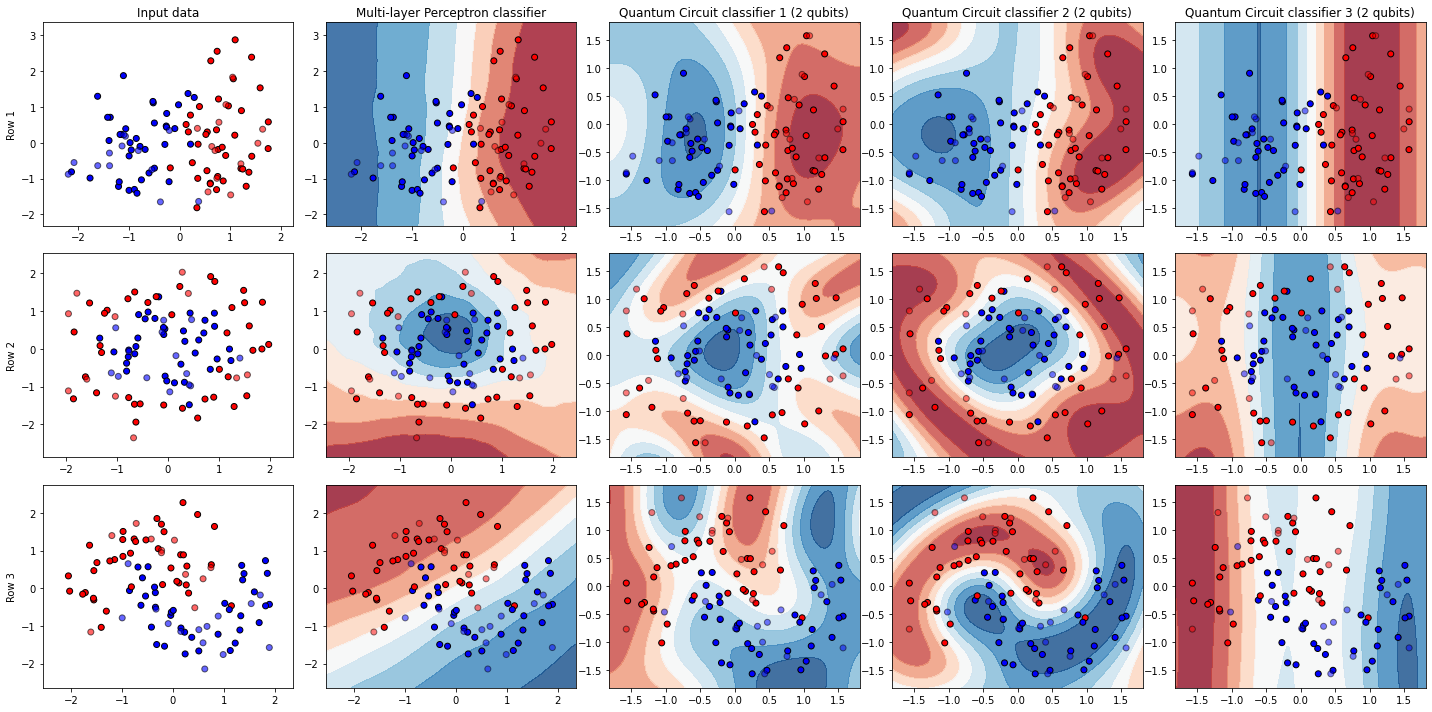

Loop count: 1


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.8771811 | Acc train: 0.7466667 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     2 | Cost: 0.8710716 | Acc train: 0.7466667 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     3 | Cost: 0.8658968 | Acc train: 0.7466667 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     4 | Cost: 0.8618603 | Acc train: 0.7466667 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     5 | Cost: 0.8547246 | Acc train: 0.7466667 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     6 | Cost: 0.8485885 | Acc train: 0.7466667 | Acc val: 0.6400000 | Acc all: 0.7400000 
Iter:     7 | Cost: 0.8413866 | Acc train: 0.7466667 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     8 | Cost: 0.8345771 | Acc train: 0.7466667 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     9 | Cost: 0.8285295 | Acc train: 0.7466667 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:    10 | Cost: 0.8246379 | Acc train: 0.7466667 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:    11 | Cost: 0.8189247 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.5062426 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     2 | Cost: 1.4984910 | Acc train: 0.5066667 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.4858157 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:     4 | Cost: 1.4724170 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.4586729 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:     6 | Cost: 1.4433618 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:     7 | Cost: 1.4249091 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:     8 | Cost: 1.4061198 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:     9 | Cost: 1.3817492 | Acc train: 0.5066667 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:    10 | Cost: 1.3493034 | Acc train: 0.5066667 | Acc val: 0.5200000 | Acc all: 0.5400000 
Iter:    11 | Cost: 1.3107039 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2219717 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     2 | Cost: 1.2212785 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     3 | Cost: 1.2216079 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     4 | Cost: 1.2218374 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     5 | Cost: 1.2218997 | Acc train: 0.6000000 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     6 | Cost: 1.2219495 | Acc train: 0.6000000 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     7 | Cost: 1.2238544 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     8 | Cost: 1.2265209 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     9 | Cost: 1.2286010 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:    10 | Cost: 1.2287584 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:    11 | Cost: 1.2319110 | Acc trai

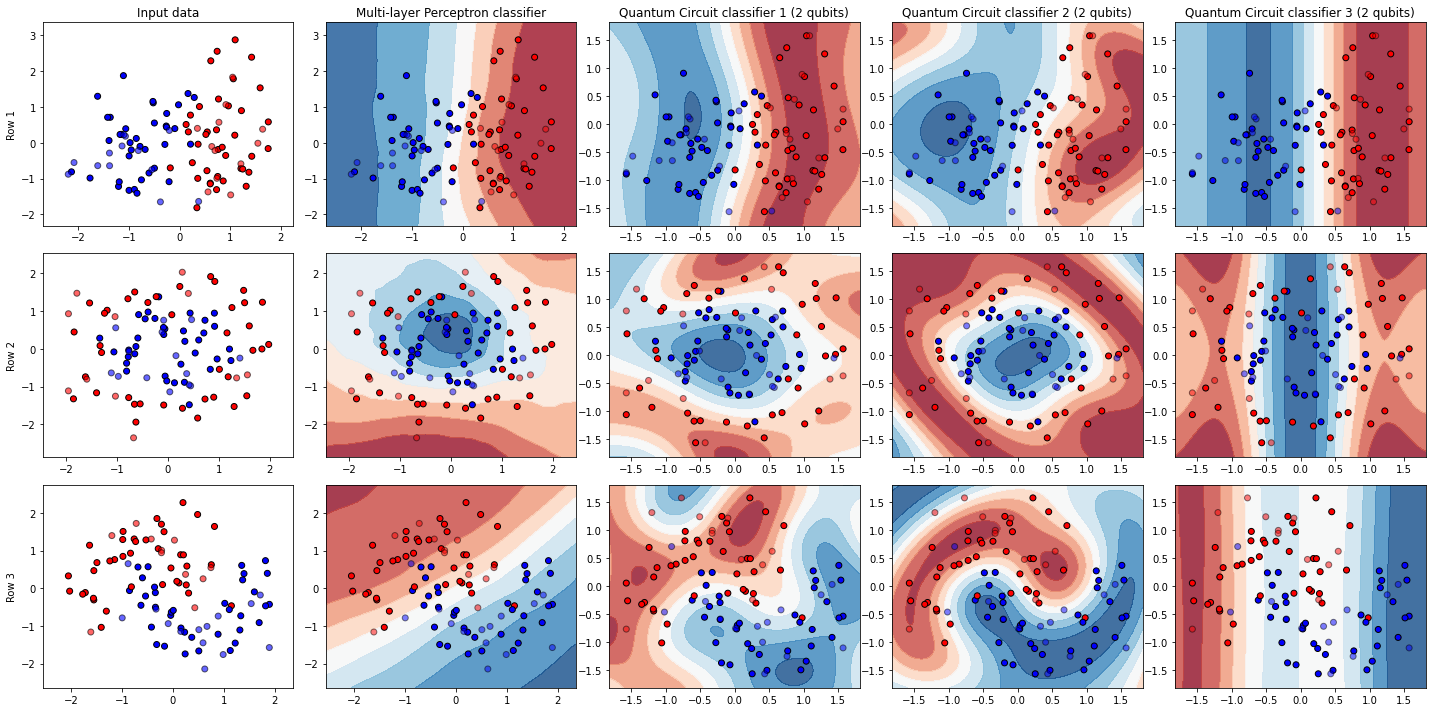

Loop count: 2


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.8791352 | Acc train: 0.7600000 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     2 | Cost: 0.8790682 | Acc train: 0.7600000 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     3 | Cost: 0.8756596 | Acc train: 0.7600000 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     4 | Cost: 0.8673708 | Acc train: 0.7466667 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     5 | Cost: 0.8613331 | Acc train: 0.7466667 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     6 | Cost: 0.8580535 | Acc train: 0.7466667 | Acc val: 0.6400000 | Acc all: 0.7400000 
Iter:     7 | Cost: 0.8552684 | Acc train: 0.7466667 | Acc val: 0.6400000 | Acc all: 0.7400000 
Iter:     8 | Cost: 0.8515076 | Acc train: 0.7466667 | Acc val: 0.6400000 | Acc all: 0.7400000 
Iter:     9 | Cost: 0.8502789 | Acc train: 0.7466667 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:    10 | Cost: 0.8471145 | Acc train: 0.7466667 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:    11 | Cost: 0.8429872 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.5050757 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     2 | Cost: 1.4959085 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:     3 | Cost: 1.4833168 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:     4 | Cost: 1.4724575 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.4625763 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:     6 | Cost: 1.4546630 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:     7 | Cost: 1.4501575 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:     8 | Cost: 1.4445002 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:     9 | Cost: 1.4396942 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:    10 | Cost: 1.4374313 | Acc train: 0.5600000 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:    11 | Cost: 1.4313674 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2223765 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     2 | Cost: 1.2217229 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     3 | Cost: 1.2218980 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     4 | Cost: 1.2212918 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     5 | Cost: 1.2194245 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     6 | Cost: 1.2181691 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     7 | Cost: 1.2181072 | Acc train: 0.6133333 | Acc val: 0.4800000 | Acc all: 0.5900000 
Iter:     8 | Cost: 1.2201558 | Acc train: 0.6133333 | Acc val: 0.4800000 | Acc all: 0.5800000 
Iter:     9 | Cost: 1.2227954 | Acc train: 0.6133333 | Acc val: 0.4800000 | Acc all: 0.5700000 
Iter:    10 | Cost: 1.2273134 | Acc train: 0.6000000 | Acc val: 0.4800000 | Acc all: 0.5700000 
Iter:    11 | Cost: 1.2362389 | Acc trai

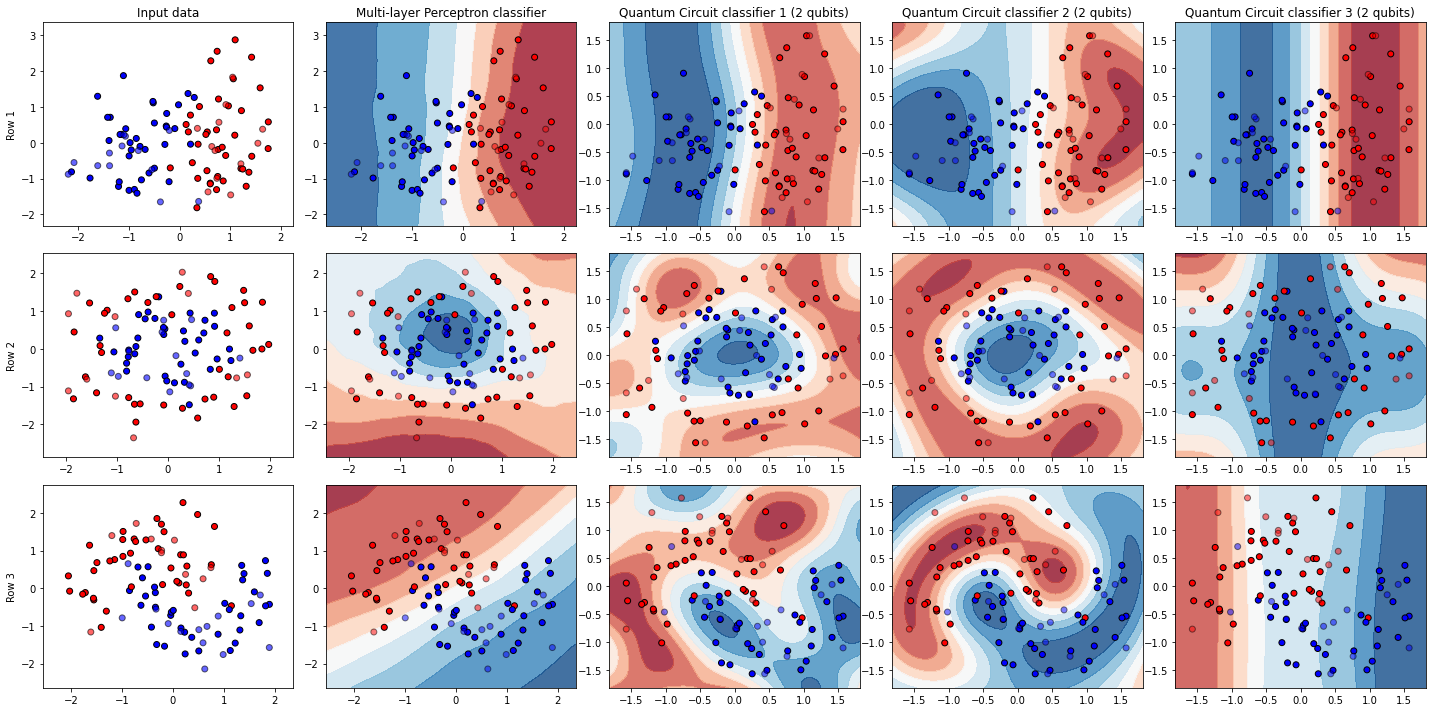

Loop count: 3


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.8760385 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     2 | Cost: 0.8700973 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7400000 
Iter:     3 | Cost: 0.8630550 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7400000 
Iter:     4 | Cost: 0.8549045 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7400000 
Iter:     5 | Cost: 0.8518953 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     6 | Cost: 0.8459210 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     7 | Cost: 0.8408865 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     8 | Cost: 0.8341023 | Acc train: 0.7333333 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     9 | Cost: 0.8287291 | Acc train: 0.7466667 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:    10 | Cost: 0.8239622 | Acc train: 0.7466667 | Acc val: 0.6400000 | Acc all: 0.7400000 
Iter:    11 | Cost: 0.8219753 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.5092747 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     2 | Cost: 1.5093097 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.5071431 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.5007699 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     5 | Cost: 1.4917068 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:     6 | Cost: 1.4830910 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:     7 | Cost: 1.4713043 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:     8 | Cost: 1.4576147 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5600000 
Iter:     9 | Cost: 1.4481228 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5600000 
Iter:    10 | Cost: 1.4360983 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5600000 
Iter:    11 | Cost: 1.4236859 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2214141 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     2 | Cost: 1.2206864 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     3 | Cost: 1.2205212 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     4 | Cost: 1.2204192 | Acc train: 0.6133333 | Acc val: 0.4800000 | Acc all: 0.5800000 
Iter:     5 | Cost: 1.2207647 | Acc train: 0.6133333 | Acc val: 0.4800000 | Acc all: 0.5800000 
Iter:     6 | Cost: 1.2207539 | Acc train: 0.6133333 | Acc val: 0.4800000 | Acc all: 0.5800000 
Iter:     7 | Cost: 1.2208755 | Acc train: 0.6133333 | Acc val: 0.4800000 | Acc all: 0.5800000 
Iter:     8 | Cost: 1.2204101 | Acc train: 0.6133333 | Acc val: 0.4800000 | Acc all: 0.5900000 
Iter:     9 | Cost: 1.2186076 | Acc train: 0.6133333 | Acc val: 0.4800000 | Acc all: 0.5900000 
Iter:    10 | Cost: 1.2169761 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:    11 | Cost: 1.2163340 | Acc trai

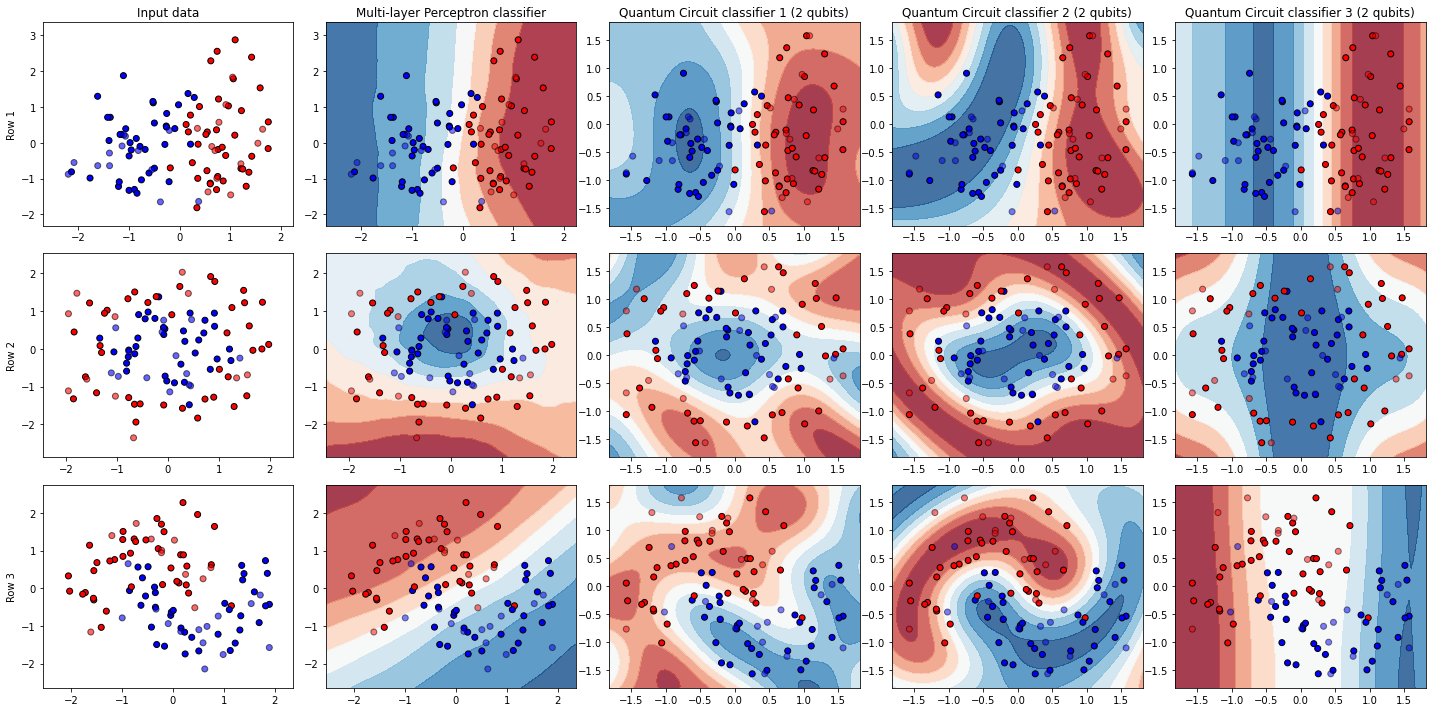

Loop count: 4


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.8796576 | Acc train: 0.7600000 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     2 | Cost: 0.8786926 | Acc train: 0.7600000 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     3 | Cost: 0.8768732 | Acc train: 0.7600000 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     4 | Cost: 0.8712727 | Acc train: 0.7600000 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     5 | Cost: 0.8677288 | Acc train: 0.7466667 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     6 | Cost: 0.8642195 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     7 | Cost: 0.8602173 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     8 | Cost: 0.8556953 | Acc train: 0.7333333 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     9 | Cost: 0.8527624 | Acc train: 0.7466667 | Acc val: 0.6400000 | Acc all: 0.7200000 
Iter:    10 | Cost: 0.8526173 | Acc train: 0.7200000 | Acc val: 0.6400000 | Acc all: 0.7200000 
Iter:    11 | Cost: 0.8533379 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.5142236 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.5149129 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.5128204 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     4 | Cost: 1.5032848 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     5 | Cost: 1.4964102 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:     6 | Cost: 1.4888777 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:     7 | Cost: 1.4822978 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:     8 | Cost: 1.4739289 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5500000 
Iter:     9 | Cost: 1.4644256 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5500000 
Iter:    10 | Cost: 1.4573456 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5500000 
Iter:    11 | Cost: 1.4455980 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2219260 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     2 | Cost: 1.2210007 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     3 | Cost: 1.2208408 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     4 | Cost: 1.2194480 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     5 | Cost: 1.2188396 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     6 | Cost: 1.2184628 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     7 | Cost: 1.2184915 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     8 | Cost: 1.2186989 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     9 | Cost: 1.2187508 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:    10 | Cost: 1.2199448 | Acc train: 0.6266667 | Acc val: 0.5600000 | Acc all: 0.5900000 
Iter:    11 | Cost: 1.2201606 | Acc trai

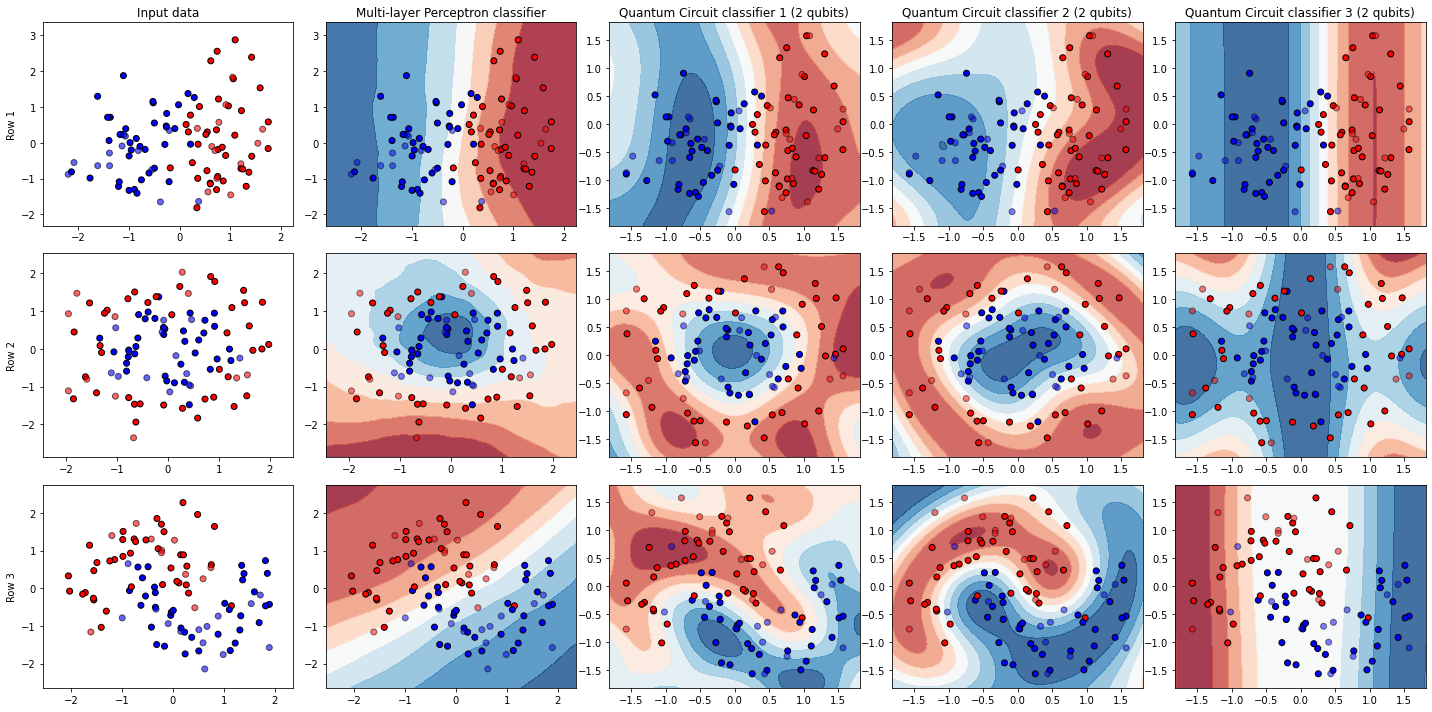

Loop count: 5


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.8773083 | Acc train: 0.7466667 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     2 | Cost: 0.8733411 | Acc train: 0.7466667 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     3 | Cost: 0.8670031 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7400000 
Iter:     4 | Cost: 0.8584256 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7400000 
Iter:     5 | Cost: 0.8496698 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7400000 
Iter:     6 | Cost: 0.8386729 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     7 | Cost: 0.8271072 | Acc train: 0.7200000 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     8 | Cost: 0.8169970 | Acc train: 0.7200000 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     9 | Cost: 0.8081810 | Acc train: 0.7333333 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:    10 | Cost: 0.8010956 | Acc train: 0.7333333 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:    11 | Cost: 0.7940429 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.5118649 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     2 | Cost: 1.5106109 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.5071953 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.5039678 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.5019178 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:     6 | Cost: 1.4974054 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:     7 | Cost: 1.4913828 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:     8 | Cost: 1.4874532 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:     9 | Cost: 1.4777400 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:    10 | Cost: 1.4671204 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:    11 | Cost: 1.4536528 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2221262 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     2 | Cost: 1.2217188 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     3 | Cost: 1.2203818 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     4 | Cost: 1.2199154 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     5 | Cost: 1.2197978 | Acc train: 0.6133333 | Acc val: 0.4800000 | Acc all: 0.5900000 
Iter:     6 | Cost: 1.2203194 | Acc train: 0.6133333 | Acc val: 0.4800000 | Acc all: 0.5800000 
Iter:     7 | Cost: 1.2203655 | Acc train: 0.6133333 | Acc val: 0.4800000 | Acc all: 0.5800000 
Iter:     8 | Cost: 1.2206890 | Acc train: 0.6133333 | Acc val: 0.4800000 | Acc all: 0.5800000 
Iter:     9 | Cost: 1.2213564 | Acc train: 0.6133333 | Acc val: 0.4800000 | Acc all: 0.5800000 
Iter:    10 | Cost: 1.2212475 | Acc train: 0.6133333 | Acc val: 0.4800000 | Acc all: 0.5800000 
Iter:    11 | Cost: 1.2213167 | Acc trai

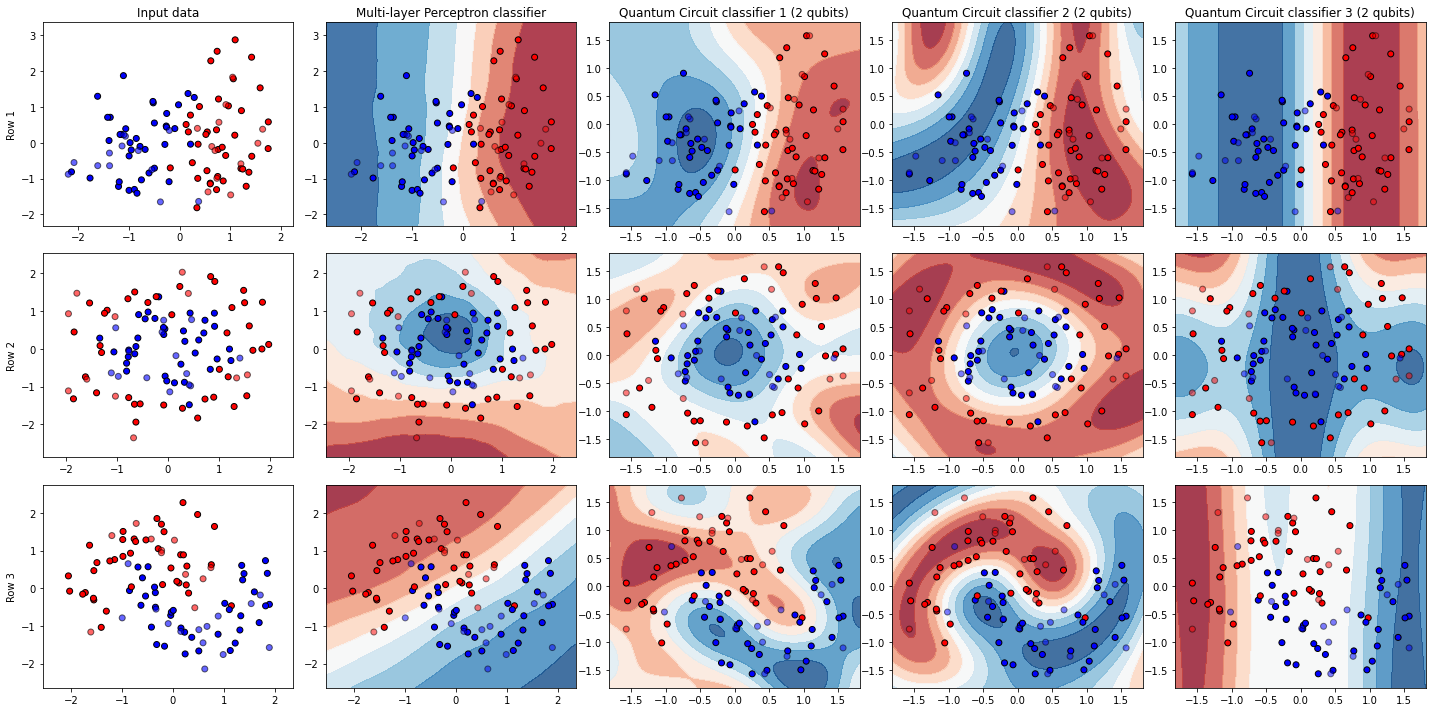

Loop count: 6


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.8784908 | Acc train: 0.7600000 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     2 | Cost: 0.8752807 | Acc train: 0.7600000 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     3 | Cost: 0.8714292 | Acc train: 0.7466667 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     4 | Cost: 0.8709566 | Acc train: 0.7333333 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     5 | Cost: 0.8716747 | Acc train: 0.7333333 | Acc val: 0.6800000 | Acc all: 0.7300000 
Iter:     6 | Cost: 0.8682650 | Acc train: 0.7200000 | Acc val: 0.6800000 | Acc all: 0.7300000 
Iter:     7 | Cost: 0.8602123 | Acc train: 0.7333333 | Acc val: 0.6800000 | Acc all: 0.7200000 
Iter:     8 | Cost: 0.8522808 | Acc train: 0.7333333 | Acc val: 0.6400000 | Acc all: 0.7400000 
Iter:     9 | Cost: 0.8429411 | Acc train: 0.7333333 | Acc val: 0.6400000 | Acc all: 0.7500000 
Iter:    10 | Cost: 0.8346081 | Acc train: 0.7333333 | Acc val: 0.6400000 | Acc all: 0.7400000 
Iter:    11 | Cost: 0.8289004 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.5108137 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     2 | Cost: 1.5050764 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.4934205 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.4835783 | Acc train: 0.5066667 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.4767923 | Acc train: 0.5066667 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:     6 | Cost: 1.4680530 | Acc train: 0.5066667 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:     7 | Cost: 1.4581220 | Acc train: 0.5066667 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:     8 | Cost: 1.4472887 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:     9 | Cost: 1.4319757 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:    10 | Cost: 1.4177878 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:    11 | Cost: 1.4016642 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2219535 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     2 | Cost: 1.2202709 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     3 | Cost: 1.2209497 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     4 | Cost: 1.2256954 | Acc train: 0.6133333 | Acc val: 0.4800000 | Acc all: 0.5800000 
Iter:     5 | Cost: 1.2346743 | Acc train: 0.6000000 | Acc val: 0.4800000 | Acc all: 0.5700000 
Iter:     6 | Cost: 1.2411571 | Acc train: 0.6000000 | Acc val: 0.4800000 | Acc all: 0.5700000 
Iter:     7 | Cost: 1.2463992 | Acc train: 0.6133333 | Acc val: 0.4800000 | Acc all: 0.5800000 
Iter:     8 | Cost: 1.2449196 | Acc train: 0.6133333 | Acc val: 0.4800000 | Acc all: 0.5800000 
Iter:     9 | Cost: 1.2430590 | Acc train: 0.6133333 | Acc val: 0.4800000 | Acc all: 0.5800000 
Iter:    10 | Cost: 1.2386618 | Acc train: 0.6133333 | Acc val: 0.4800000 | Acc all: 0.5800000 
Iter:    11 | Cost: 1.2328824 | Acc trai

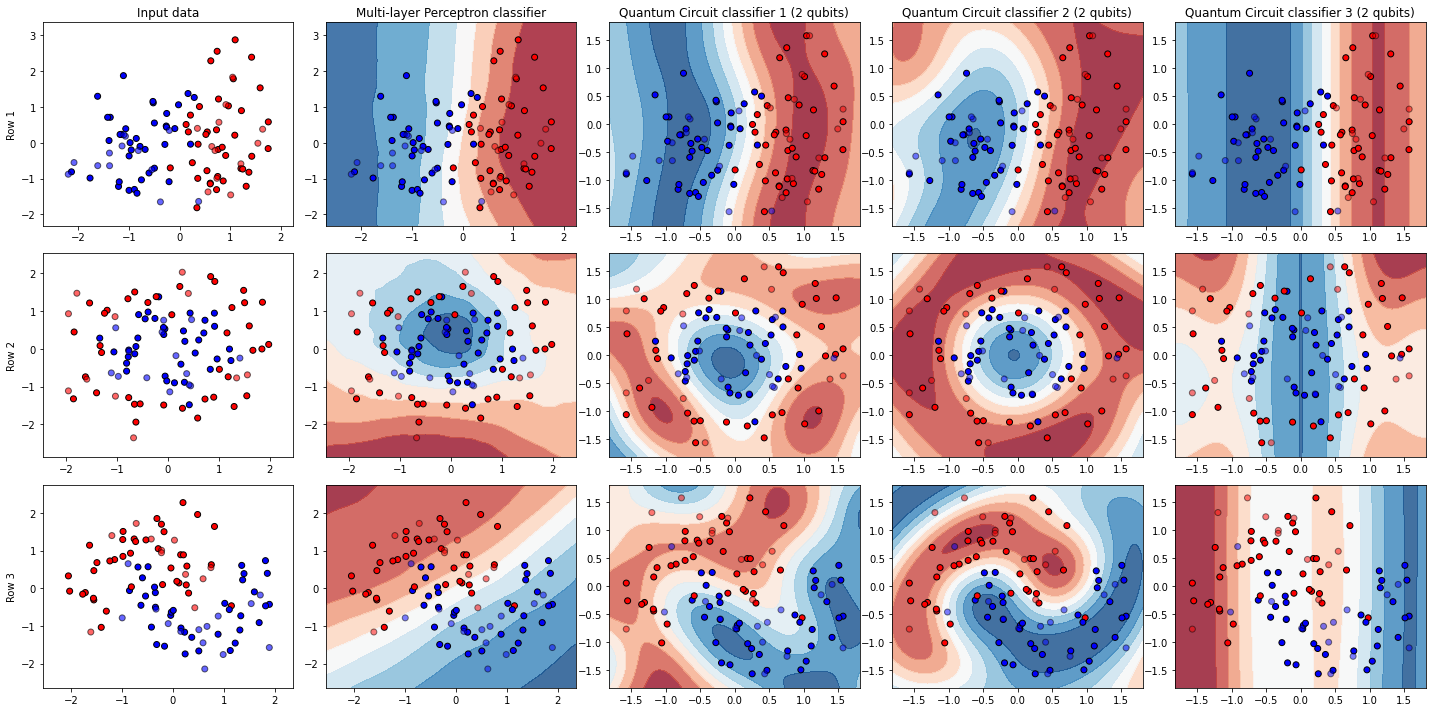

Loop count: 7


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.8758466 | Acc train: 0.7600000 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     2 | Cost: 0.8714874 | Acc train: 0.7466667 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     3 | Cost: 0.8669141 | Acc train: 0.7466667 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     4 | Cost: 0.8612486 | Acc train: 0.7466667 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     5 | Cost: 0.8525755 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7400000 
Iter:     6 | Cost: 0.8446673 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7400000 
Iter:     7 | Cost: 0.8334540 | Acc train: 0.7333333 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     8 | Cost: 0.8206168 | Acc train: 0.7333333 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     9 | Cost: 0.8071569 | Acc train: 0.7200000 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:    10 | Cost: 0.7947598 | Acc train: 0.7200000 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:    11 | Cost: 0.7820924 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.5117158 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     2 | Cost: 1.5087662 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.5042829 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:     4 | Cost: 1.5040995 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.5022624 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:     6 | Cost: 1.4982634 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:     7 | Cost: 1.4950777 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:     8 | Cost: 1.4899859 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:     9 | Cost: 1.4838870 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:    10 | Cost: 1.4806654 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:    11 | Cost: 1.4772956 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2217849 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     2 | Cost: 1.2222122 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     3 | Cost: 1.2234865 | Acc train: 0.6266667 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     4 | Cost: 1.2229784 | Acc train: 0.6266667 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     5 | Cost: 1.2227263 | Acc train: 0.6133333 | Acc val: 0.5600000 | Acc all: 0.5800000 
Iter:     6 | Cost: 1.2225194 | Acc train: 0.6133333 | Acc val: 0.5600000 | Acc all: 0.6000000 
Iter:     7 | Cost: 1.2189315 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.6000000 
Iter:     8 | Cost: 1.2151562 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.6000000 
Iter:     9 | Cost: 1.2151566 | Acc train: 0.5733333 | Acc val: 0.4800000 | Acc all: 0.5700000 
Iter:    10 | Cost: 1.2197642 | Acc train: 0.5733333 | Acc val: 0.4800000 | Acc all: 0.5500000 
Iter:    11 | Cost: 1.2272299 | Acc trai

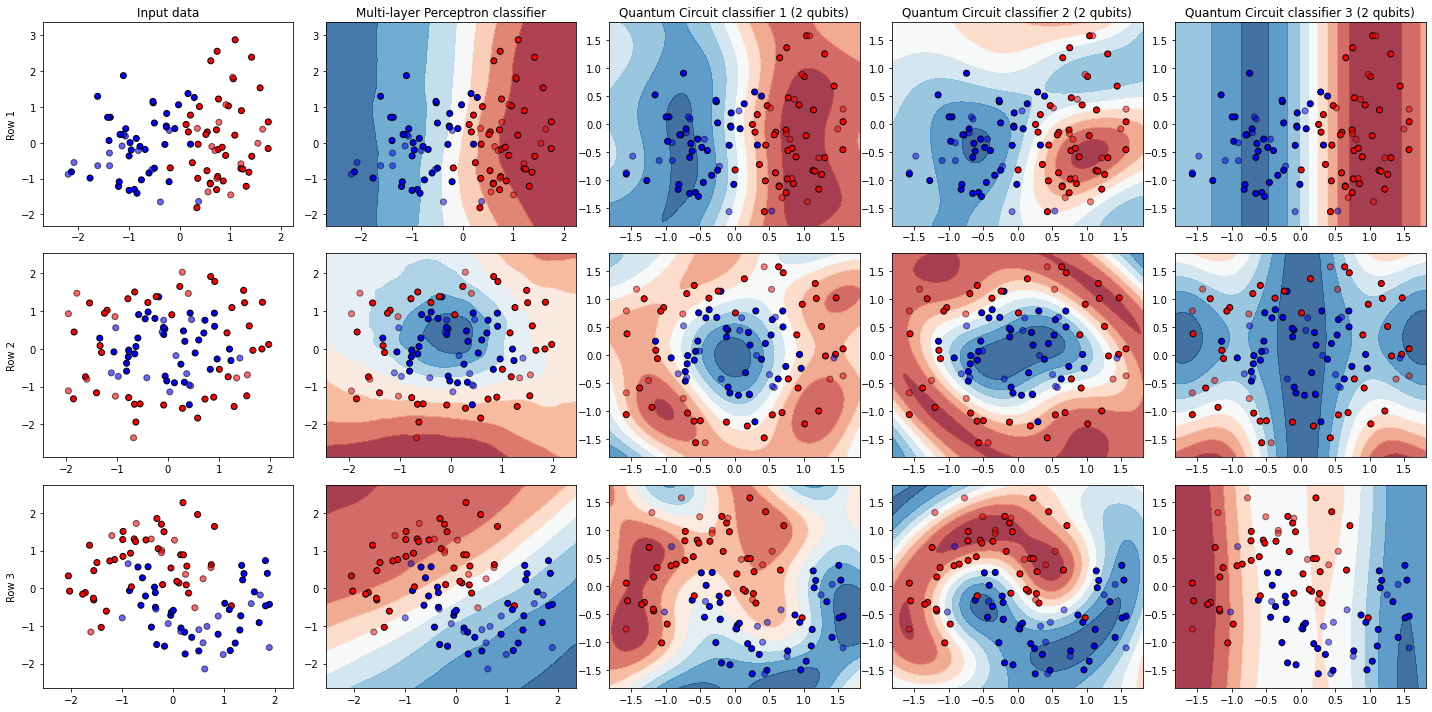

Loop count: 8


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.8786796 | Acc train: 0.7600000 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     2 | Cost: 0.8803439 | Acc train: 0.7600000 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     3 | Cost: 0.8823722 | Acc train: 0.7600000 | Acc val: 0.6400000 | Acc all: 0.7200000 
Iter:     4 | Cost: 0.8825650 | Acc train: 0.7600000 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     5 | Cost: 0.8769455 | Acc train: 0.7600000 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     6 | Cost: 0.8697689 | Acc train: 0.7466667 | Acc val: 0.6400000 | Acc all: 0.7400000 
Iter:     7 | Cost: 0.8651407 | Acc train: 0.7466667 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     8 | Cost: 0.8629299 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     9 | Cost: 0.8603305 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:    10 | Cost: 0.8559115 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:    11 | Cost: 0.8525492 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.5090634 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     2 | Cost: 1.5055842 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.5003821 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:     4 | Cost: 1.4896673 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.4841028 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:     6 | Cost: 1.4831127 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:     7 | Cost: 1.4821617 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5500000 
Iter:     8 | Cost: 1.4846359 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:     9 | Cost: 1.4936221 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:    10 | Cost: 1.5016340 | Acc train: 0.5466667 | Acc val: 0.4800000 | Acc all: 0.5500000 
Iter:    11 | Cost: 1.5207935 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2222205 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     2 | Cost: 1.2210304 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     3 | Cost: 1.2204661 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     4 | Cost: 1.2206485 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     5 | Cost: 1.2221122 | Acc train: 0.6133333 | Acc val: 0.4800000 | Acc all: 0.5800000 
Iter:     6 | Cost: 1.2246588 | Acc train: 0.6133333 | Acc val: 0.4800000 | Acc all: 0.5800000 
Iter:     7 | Cost: 1.2266500 | Acc train: 0.6133333 | Acc val: 0.4800000 | Acc all: 0.5800000 
Iter:     8 | Cost: 1.2271900 | Acc train: 0.6000000 | Acc val: 0.4800000 | Acc all: 0.5700000 
Iter:     9 | Cost: 1.2262311 | Acc train: 0.6000000 | Acc val: 0.4800000 | Acc all: 0.5700000 
Iter:    10 | Cost: 1.2253070 | Acc train: 0.6000000 | Acc val: 0.4800000 | Acc all: 0.5700000 
Iter:    11 | Cost: 1.2223722 | Acc trai

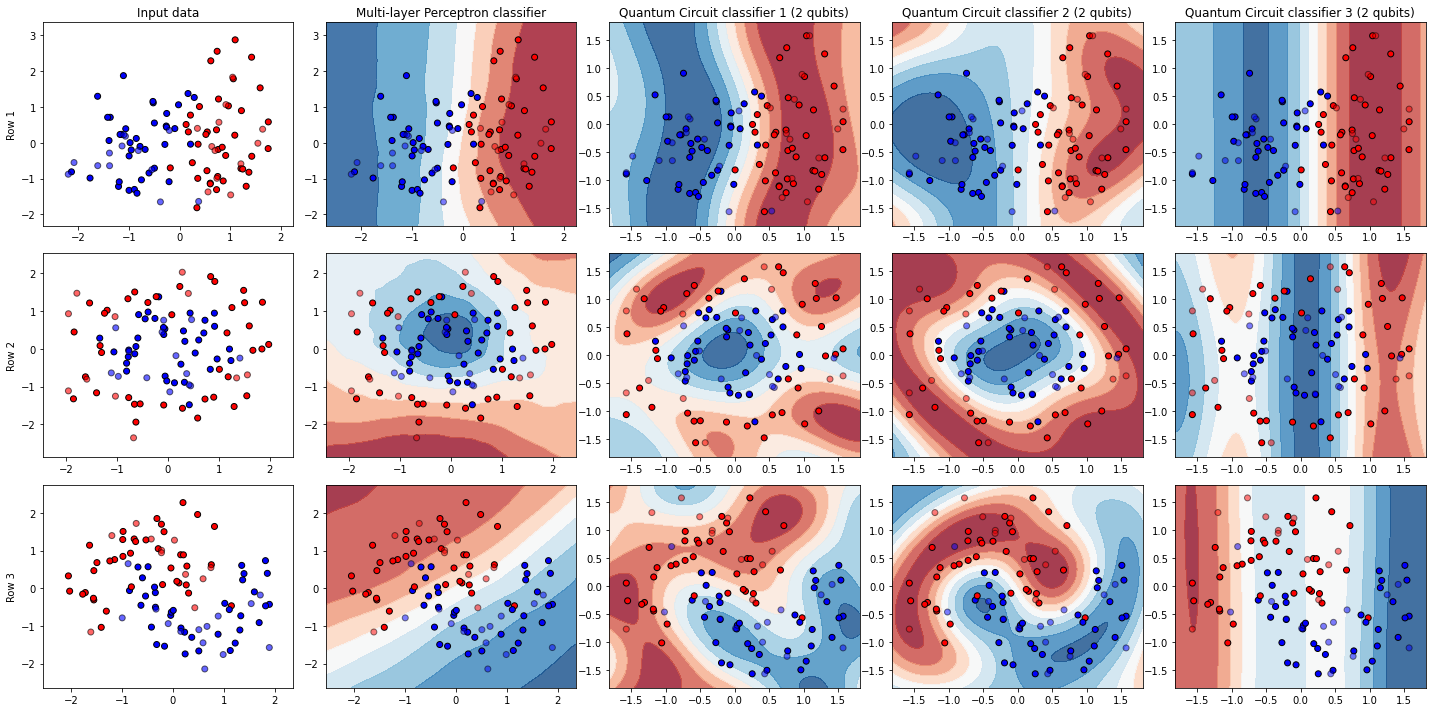

Loop count: 9


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.8786772 | Acc train: 0.7600000 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     2 | Cost: 0.8778232 | Acc train: 0.7600000 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     3 | Cost: 0.8769998 | Acc train: 0.7600000 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     4 | Cost: 0.8770820 | Acc train: 0.7466667 | Acc val: 0.6400000 | Acc all: 0.7100000 
Iter:     5 | Cost: 0.8757008 | Acc train: 0.7466667 | Acc val: 0.6400000 | Acc all: 0.7100000 
Iter:     6 | Cost: 0.8744920 | Acc train: 0.7466667 | Acc val: 0.6400000 | Acc all: 0.7100000 
Iter:     7 | Cost: 0.8717672 | Acc train: 0.7466667 | Acc val: 0.6400000 | Acc all: 0.7100000 
Iter:     8 | Cost: 0.8686362 | Acc train: 0.7466667 | Acc val: 0.6400000 | Acc all: 0.7100000 
Iter:     9 | Cost: 0.8611699 | Acc train: 0.7466667 | Acc val: 0.6400000 | Acc all: 0.7100000 
Iter:    10 | Cost: 0.8545369 | Acc train: 0.7600000 | Acc val: 0.6400000 | Acc all: 0.7400000 
Iter:    11 | Cost: 0.8445511 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.5118338 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     2 | Cost: 1.5050666 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.4957452 | Acc train: 0.5066667 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.4880556 | Acc train: 0.5066667 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     5 | Cost: 1.4827245 | Acc train: 0.5066667 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     6 | Cost: 1.4744136 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     7 | Cost: 1.4620355 | Acc train: 0.5200000 | Acc val: 0.5200000 | Acc all: 0.5100000 
Iter:     8 | Cost: 1.4456882 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:     9 | Cost: 1.4267722 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5200000 
Iter:    10 | Cost: 1.4113930 | Acc train: 0.5200000 | Acc val: 0.5600000 | Acc all: 0.5300000 
Iter:    11 | Cost: 1.4053848 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2222951 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     2 | Cost: 1.2224971 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     3 | Cost: 1.2215013 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     4 | Cost: 1.2216028 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     5 | Cost: 1.2228557 | Acc train: 0.6133333 | Acc val: 0.4800000 | Acc all: 0.5800000 
Iter:     6 | Cost: 1.2278941 | Acc train: 0.6133333 | Acc val: 0.4800000 | Acc all: 0.5700000 
Iter:     7 | Cost: 1.2316007 | Acc train: 0.6266667 | Acc val: 0.4800000 | Acc all: 0.5800000 
Iter:     8 | Cost: 1.2375106 | Acc train: 0.6133333 | Acc val: 0.4800000 | Acc all: 0.5800000 
Iter:     9 | Cost: 1.2405918 | Acc train: 0.6133333 | Acc val: 0.4800000 | Acc all: 0.5800000 
Iter:    10 | Cost: 1.2463418 | Acc train: 0.6133333 | Acc val: 0.4800000 | Acc all: 0.5800000 
Iter:    11 | Cost: 1.2475067 | Acc trai

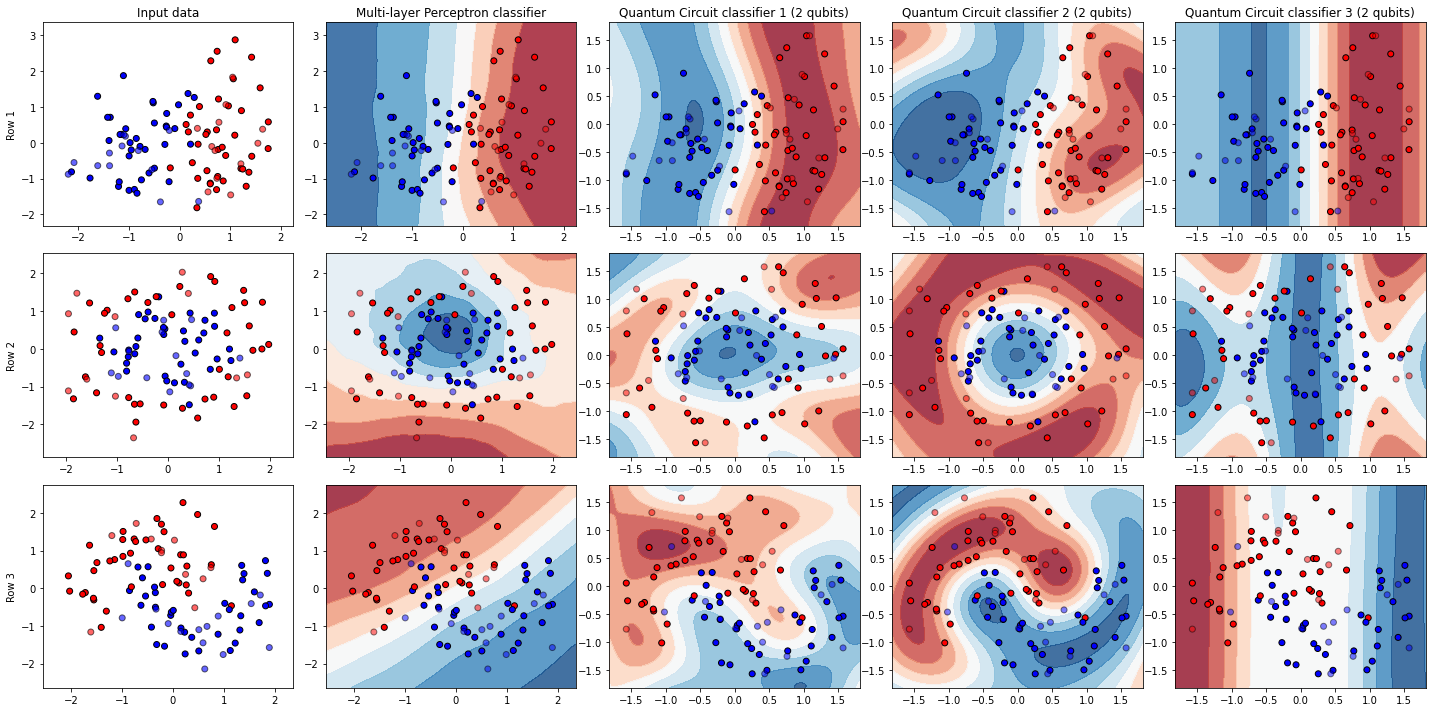

Loop count: 10


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.8787654 | Acc train: 0.7466667 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     2 | Cost: 0.8775546 | Acc train: 0.7466667 | Acc val: 0.6000000 | Acc all: 0.7100000 
Iter:     3 | Cost: 0.8747891 | Acc train: 0.7466667 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     4 | Cost: 0.8707101 | Acc train: 0.7466667 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     5 | Cost: 0.8644222 | Acc train: 0.7466667 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     6 | Cost: 0.8588032 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     7 | Cost: 0.8554796 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     8 | Cost: 0.8493849 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     9 | Cost: 0.8442800 | Acc train: 0.7200000 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:    10 | Cost: 0.8392663 | Acc train: 0.7200000 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:    11 | Cost: 0.8333056 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.5118891 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     2 | Cost: 1.5034947 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.4945659 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:     4 | Cost: 1.4798741 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.4653069 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:     6 | Cost: 1.4451795 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5500000 
Iter:     7 | Cost: 1.4246583 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5500000 
Iter:     8 | Cost: 1.3995944 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:     9 | Cost: 1.3733787 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5300000 
Iter:    10 | Cost: 1.3528593 | Acc train: 0.5333333 | Acc val: 0.5200000 | Acc all: 0.5300000 
Iter:    11 | Cost: 1.3335887 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2217629 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     2 | Cost: 1.2202685 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     3 | Cost: 1.2207325 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     4 | Cost: 1.2224246 | Acc train: 0.6133333 | Acc val: 0.4800000 | Acc all: 0.5800000 
Iter:     5 | Cost: 1.2246862 | Acc train: 0.6133333 | Acc val: 0.4800000 | Acc all: 0.5800000 
Iter:     6 | Cost: 1.2254409 | Acc train: 0.6133333 | Acc val: 0.4800000 | Acc all: 0.5800000 
Iter:     7 | Cost: 1.2273009 | Acc train: 0.6000000 | Acc val: 0.4800000 | Acc all: 0.5800000 
Iter:     8 | Cost: 1.2303789 | Acc train: 0.6000000 | Acc val: 0.4800000 | Acc all: 0.5700000 
Iter:     9 | Cost: 1.2366184 | Acc train: 0.6000000 | Acc val: 0.4800000 | Acc all: 0.5700000 
Iter:    10 | Cost: 1.2410820 | Acc train: 0.6000000 | Acc val: 0.4800000 | Acc all: 0.5700000 
Iter:    11 | Cost: 1.2409422 | Acc trai

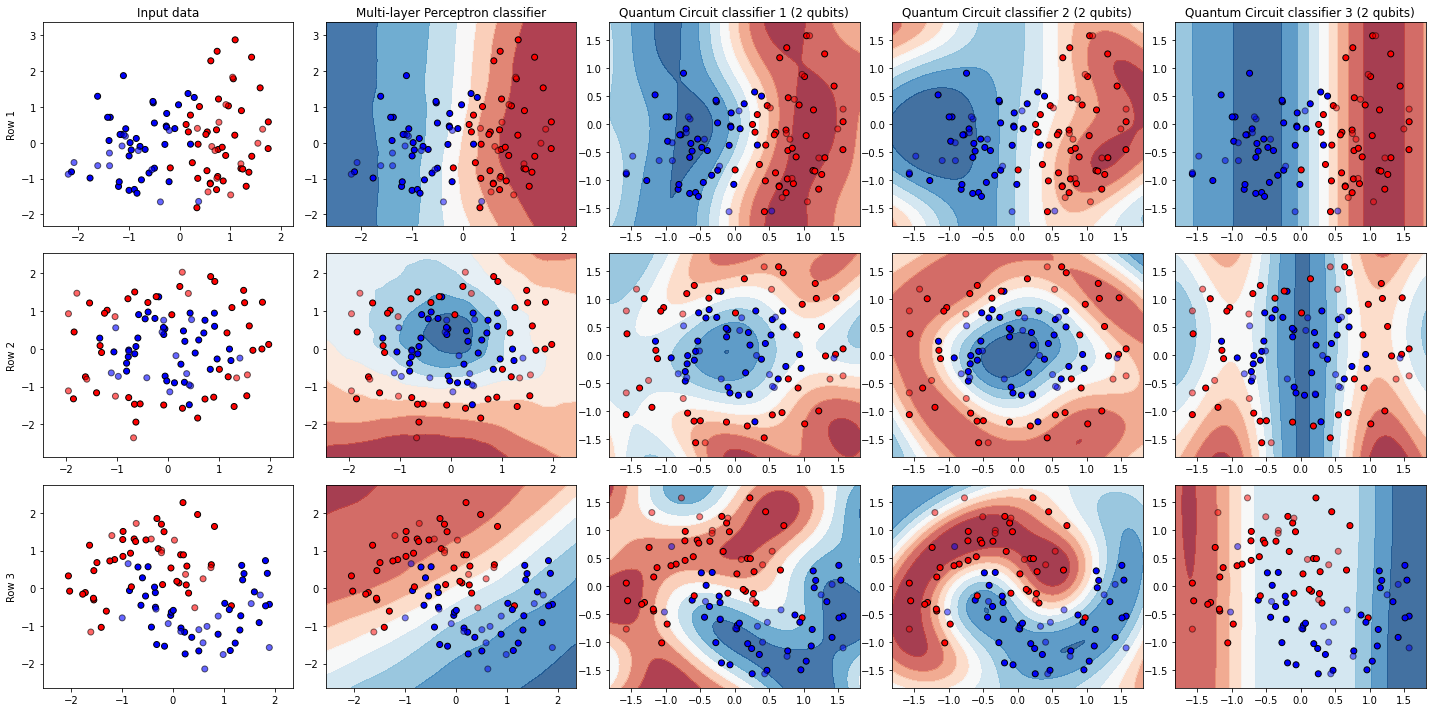

Loop count: 11


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.8761401 | Acc train: 0.7600000 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     2 | Cost: 0.8674726 | Acc train: 0.7466667 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     3 | Cost: 0.8586595 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     4 | Cost: 0.8504862 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     5 | Cost: 0.8450407 | Acc train: 0.7200000 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     6 | Cost: 0.8363484 | Acc train: 0.7200000 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     7 | Cost: 0.8268517 | Acc train: 0.7066667 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     8 | Cost: 0.8196803 | Acc train: 0.7066667 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     9 | Cost: 0.8146478 | Acc train: 0.7066667 | Acc val: 0.6800000 | Acc all: 0.7200000 
Iter:    10 | Cost: 0.8112331 | Acc train: 0.7200000 | Acc val: 0.6800000 | Acc all: 0.7300000 
Iter:    11 | Cost: 0.8122670 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.5082478 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     2 | Cost: 1.5034292 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.4954281 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:     4 | Cost: 1.4827977 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.4703022 | Acc train: 0.5333333 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:     6 | Cost: 1.4484793 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:     7 | Cost: 1.4314219 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5500000 
Iter:     8 | Cost: 1.4053957 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5500000 
Iter:     9 | Cost: 1.3762669 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5500000 
Iter:    10 | Cost: 1.3542588 | Acc train: 0.5066667 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:    11 | Cost: 1.3276700 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2221920 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     2 | Cost: 1.2226308 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     3 | Cost: 1.2221930 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     4 | Cost: 1.2211818 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     5 | Cost: 1.2204873 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     6 | Cost: 1.2203784 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     7 | Cost: 1.2213776 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     8 | Cost: 1.2230294 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     9 | Cost: 1.2245471 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:    10 | Cost: 1.2262756 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:    11 | Cost: 1.2253143 | Acc trai

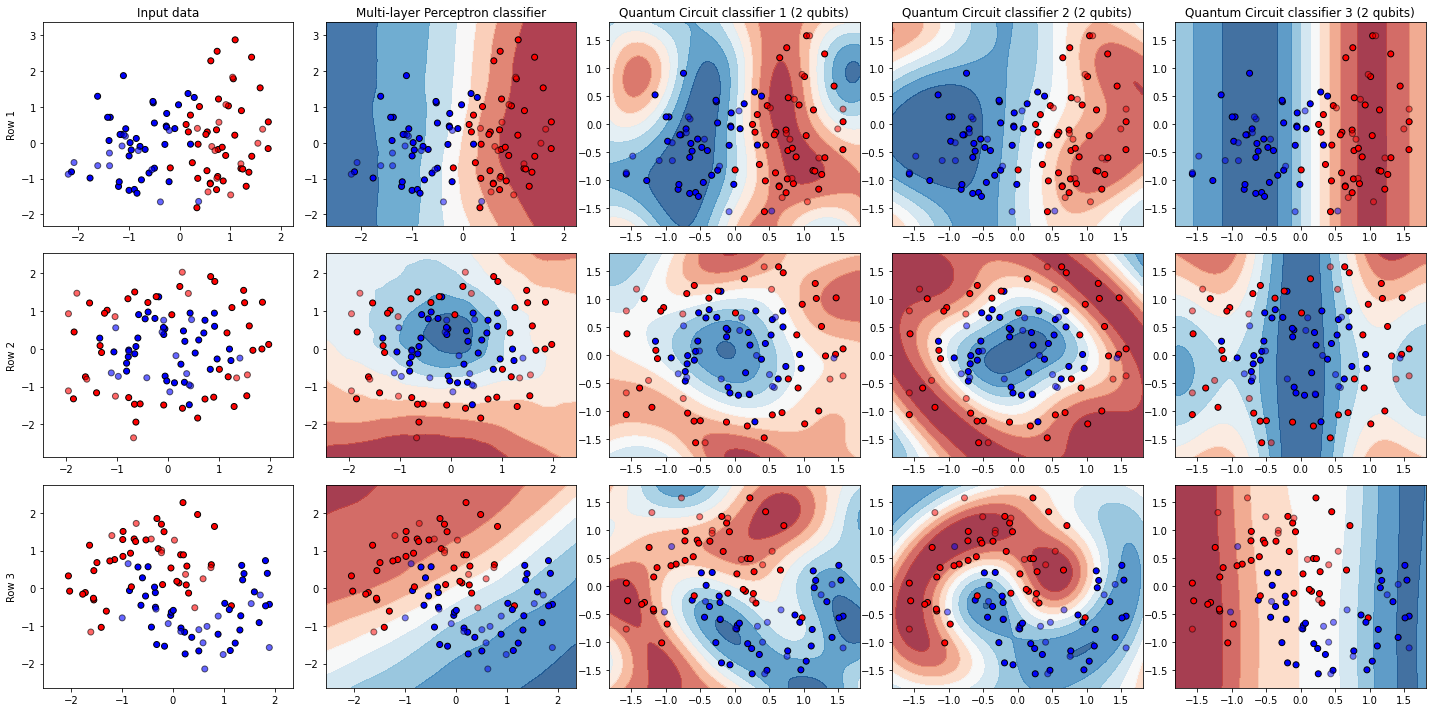

Loop count: 12


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.8768785 | Acc train: 0.7600000 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     2 | Cost: 0.8752820 | Acc train: 0.7600000 | Acc val: 0.6000000 | Acc all: 0.7200000 
Iter:     3 | Cost: 0.8759477 | Acc train: 0.7600000 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     4 | Cost: 0.8759897 | Acc train: 0.7600000 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:     5 | Cost: 0.8750875 | Acc train: 0.7600000 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     6 | Cost: 0.8747486 | Acc train: 0.7600000 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     7 | Cost: 0.8725501 | Acc train: 0.7600000 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     8 | Cost: 0.8696115 | Acc train: 0.7600000 | Acc val: 0.6400000 | Acc all: 0.7300000 
Iter:     9 | Cost: 0.8628461 | Acc train: 0.7600000 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:    10 | Cost: 0.8548457 | Acc train: 0.7333333 | Acc val: 0.6000000 | Acc all: 0.7300000 
Iter:    11 | Cost: 0.8459956 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.5139550 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.5121901 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.5072960 | Acc train: 0.5066667 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     4 | Cost: 1.5042775 | Acc train: 0.5066667 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     5 | Cost: 1.4992372 | Acc train: 0.5066667 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:     6 | Cost: 1.4955542 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     7 | Cost: 1.4890550 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     8 | Cost: 1.4825468 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:     9 | Cost: 1.4773225 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5200000 
Iter:    10 | Cost: 1.4760464 | Acc train: 0.5200000 | Acc val: 0.4800000 | Acc all: 0.5100000 
Iter:    11 | Cost: 1.4762610 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2223516 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     2 | Cost: 1.2229651 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     3 | Cost: 1.2244538 | Acc train: 0.6133333 | Acc val: 0.5600000 | Acc all: 0.6000000 
Iter:     4 | Cost: 1.2256626 | Acc train: 0.6000000 | Acc val: 0.5600000 | Acc all: 0.5900000 
Iter:     5 | Cost: 1.2289284 | Acc train: 0.6000000 | Acc val: 0.5600000 | Acc all: 0.5900000 
Iter:     6 | Cost: 1.2316048 | Acc train: 0.6000000 | Acc val: 0.5600000 | Acc all: 0.6000000 
Iter:     7 | Cost: 1.2345516 | Acc train: 0.6266667 | Acc val: 0.5600000 | Acc all: 0.6000000 
Iter:     8 | Cost: 1.2373434 | Acc train: 0.6266667 | Acc val: 0.5600000 | Acc all: 0.6100000 
Iter:     9 | Cost: 1.2373583 | Acc train: 0.6266667 | Acc val: 0.5600000 | Acc all: 0.6100000 
Iter:    10 | Cost: 1.2433914 | Acc train: 0.6133333 | Acc val: 0.5600000 | Acc all: 0.6000000 
Iter:    11 | Cost: 1.2477143 | Acc trai

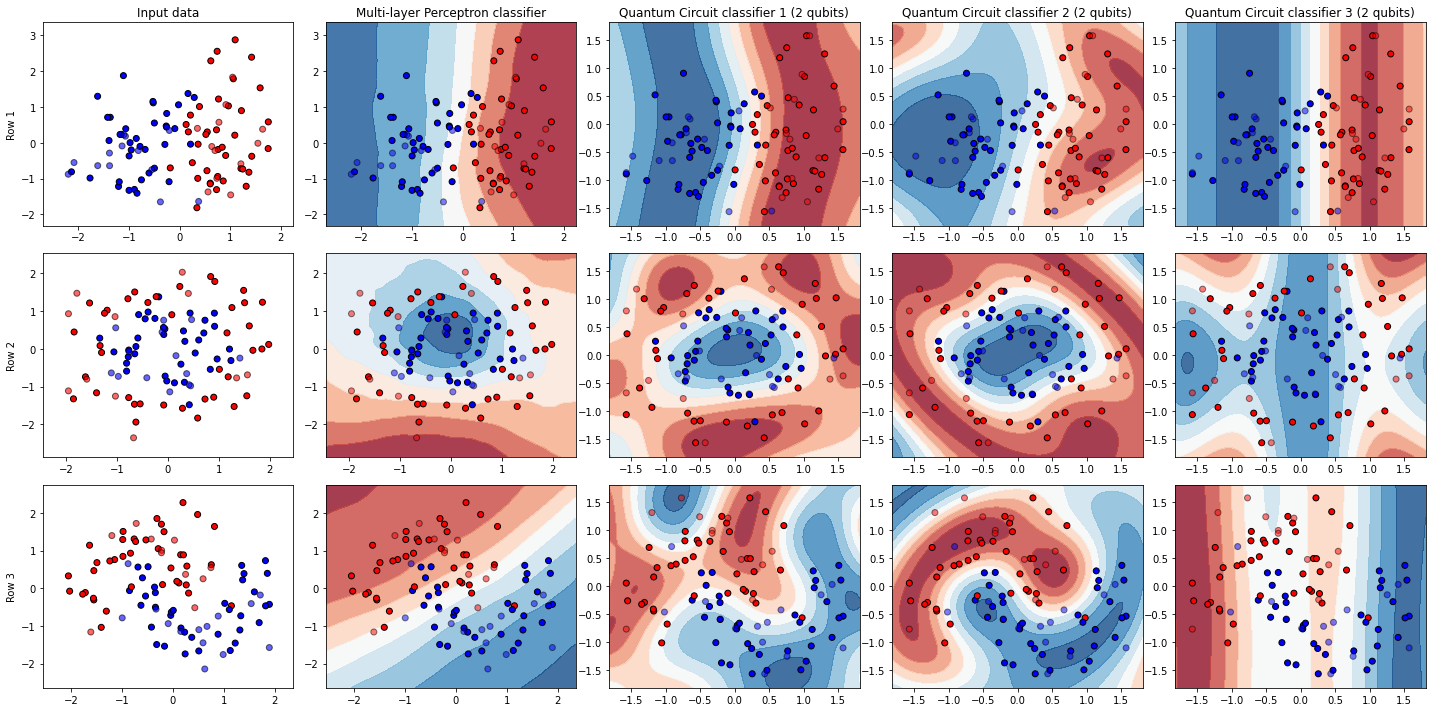

scores: [[[0.96 0.52 0.8 ]
  [0.96 0.52 0.8 ]
  [0.96 0.52 0.8 ]
  [0.96 0.52 0.8 ]
  [0.96 0.52 0.8 ]
  [0.96 0.52 0.8 ]
  [0.96 0.52 0.8 ]
  [0.96 0.52 0.8 ]
  [0.96 0.52 0.8 ]
  [0.96 0.52 0.8 ]
  [0.96 0.52 0.8 ]
  [0.96 0.52 0.8 ]
  [0.96 0.52 0.8 ]]

 [[0.96 0.84 0.8 ]
  [0.96 0.84 0.76]
  [0.96 0.8  0.76]
  [0.96 0.68 0.84]
  [0.96 0.88 0.84]
  [0.96 0.92 0.76]
  [0.96 0.68 0.88]
  [0.96 0.76 0.76]
  [0.92 0.8  0.84]
  [0.96 0.96 0.8 ]
  [0.96 0.84 0.88]
  [0.92 0.8  0.8 ]
  [0.96 0.84 0.72]]

 [[0.96 0.84 0.88]
  [0.92 0.96 0.84]
  [0.96 0.96 0.88]
  [0.96 0.92 0.88]
  [0.96 0.84 0.88]
  [0.92 0.88 0.88]
  [0.96 0.96 0.84]
  [0.84 0.96 0.92]
  [0.96 0.96 0.88]
  [0.96 0.96 0.88]
  [0.96 0.84 0.88]
  [0.96 0.96 0.88]
  [0.92 0.96 0.88]]

 [[0.96 0.72 0.52]
  [0.96 0.72 0.56]
  [0.96 0.64 0.6 ]
  [0.96 0.8  0.64]
  [0.96 0.68 0.64]
  [0.96 0.72 0.52]
  [0.96 0.72 0.56]
  [0.96 0.6  0.6 ]
  [0.96 0.56 0.6 ]
  [0.96 0.56 0.52]
  [0.96 0.6  0.6 ]
  [0.96 0.68 0.64]
  [0.96 0.6  0.6 

In [5]:
# h = 0.02  # step size in the mesh
h = 0.03  # step size in the mesh
n_samples = 100

names = [
    "Multi-layer Perceptron classifier",
    # "Linear SVM",
    "Quantum Circuit classifier 1 (2 qubits)",
    "Quantum Circuit classifier 2 (2 qubits)",
    "Quantum Circuit classifier 3 (2 qubits)",
]

classifiers = [
  MLPClassifier(random_state=1, hidden_layer_sizes=(100,100,100), max_iter=max_iterations, 
                    solver="sgd", nesterovs_momentum=True),
  # SVC(kernel="linear", C=0.025),
  [vc_quantum, vc_classifier_1, init_weights_1, circuit_1],
  [vc_quantum, vc_classifier_2, init_weights_2, circuit_2],
  [vc_quantum, vc_classifier_3, init_weights_3, circuit_3],
]

X, y = make_classification(
    n_samples=n_samples,
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = numpy.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    linearly_separable,
    make_circles(n_samples=n_samples, noise=0.2, factor=0.5, random_state=1),
    make_moons(n_samples=n_samples, noise=0.3, random_state=0),
]

# initalize scores array
scores = np.zeros(shape=(len(classifiers),loop_count,len(datasets)))

#############
# Main Loop #
#############
for l_count in range(loop_count):
  print("Loop count:", l_count)
  figure = plt.figure(figsize=(20, 10))
  # Figure: set white background
  figure.patch.set_facecolor('xkcd:white')
  i = 1
  # iterate over datasets
  for ds_cnt, ds in enumerate(datasets):
      # preprocess dataset, split into training and test part
      X, y = ds

      X = StandardScaler().fit_transform(X)
      X_train, X_test, y_train, y_test = train_test_split(
          X, y, test_size=0.25, random_state=1
      )

      x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
      y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
      xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
      
      # scale data for quantum data
      y_train_quantum = np.where(y_train==0, y_train-1, y_train)
      y_test_quantum = np.where(y_test==0, y_test-1, y_test)
      y_quantum = np.where(y==0, y-1, y)
      
      scale_value=pi/2
      X_scaled = MinMaxScaler(feature_range=(-scale_value,scale_value), copy=True).fit_transform(X)
      X_train_scaled = MinMaxScaler(feature_range=(-scale_value,scale_value), copy=True).fit_transform(X_train)
      X_test_scaled = MinMaxScaler(feature_range=(-scale_value,scale_value), copy=True).fit_transform(X_test)

      x_min_scaled, x_max_scaled = X_scaled[:, 0].min() - 0.25, X_scaled[:, 0].max() + 0.25
      y_min_scaled, y_max_scaled = X_scaled[:, 1].min() - 0.25, X_scaled[:, 1].max() + 0.25
      xx_scaled, yy_scaled = np.meshgrid(np.arange(x_min_scaled, x_max_scaled, h), np.arange(y_min_scaled, y_max_scaled, h))

      # just plot the dataset first
      cm = plt.cm.RdBu
      cm_bright = ListedColormap(["#FF0000", "#0000FF"])
      ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
      if ds_cnt == 0:
          ax.set_title("Input data")
      ax.set(ylabel='Row ' + str(ds_cnt+1))
      # Plot the training points
      ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
      # Plot the testing points
      ax.scatter(
          X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
      )
      ax.set_xlim(xx.min(), xx.max())
      ax.set_ylim(yy.min(), yy.max())
      # ax.set_xticks(())
      # ax.set_yticks(())
      i += 1

      classifier_count=0
      # iterate over classifiers
      for name, clf in zip(names, classifiers):
          
          ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
          
          if 'Quantum' in name:
            # Quantum circuit #
            vars, score = clf[0](clf[1], clf[2], X_train_scaled, X_test_scaled, X_scaled, y_train_quantum, y_test_quantum, y_quantum)
            Z = np.array(
              [clf[1](vars, f) for f in np.c_[xx_scaled.ravel(), yy_scaled.ravel()]]
            )

            # Put the result into a color plot
            Z = Z.reshape(xx_scaled.shape)
            ax.contourf(xx_scaled, yy_scaled, Z, cmap=cm, alpha=0.8)
            
            # Plot the training points
            ax.scatter(
                X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train_quantum, cmap=cm_bright, edgecolors="k"
            )
            # Plot the testing points
            ax.scatter(
                X_test_scaled[:, 0],
                X_test_scaled[:, 1],
                c=y_test_quantum,
                cmap=cm_bright,
                edgecolors="k",
                alpha=0.5,
            )
            
            ax.set_xlim(xx_scaled.min(), xx_scaled.max())
            ax.set_ylim(yy_scaled.min(), yy_scaled.max())

            # print scores
            # ax.text(
            #   xx_scaled.max() - 0.15,
            #   yy_scaled.min() + 0.15,
            #   ("Score: %.2f" % score).lstrip("0"),
            #   size=15,
            #   horizontalalignment="right",
            # )
            
          else:
            # Classical circuits #
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test)

            # Plot the decision boundary. For that, we will assign a color to each
            # point in the mesh [x_min, x_max]x[y_min, y_max].
            if hasattr(clf, "decision_function"):
                Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
            else:
                Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

            # Put the result into a color plot
            Z = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)
                
            # Plot the training points
            ax.scatter(
                X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
            )
            # Plot the testing points
            ax.scatter(
                X_test[:, 0],
                X_test[:, 1],
                c=y_test,
                cmap=cm_bright,
                edgecolors="k",
                alpha=0.5,
            )

            ax.set_xlim(xx.min(), xx.max())
            ax.set_ylim(yy.min(), yy.max())

            # print scores
            # ax.text(
            #     xx.max() - 0.3,
            #     yy.min() + 0.3,
            #     ("Score: %.2f" % score).lstrip("0"),
            #     size=15,
            #     horizontalalignment="right",
            # )
            
          scores[classifier_count][l_count][ds_cnt] = score
          # ax.set_xticks(())
          # ax.set_yticks(())
          if ds_cnt == 0:
              ax.set_title(name)
          i += 1
          classifier_count += 1

  plt.tight_layout()
  plt.show()

print("scores:", scores)


In [6]:
for name, clf in zip(names, classifiers):
    if 'Quantum' in name:
      print(name)
      print(clf[3].draw())


Quantum Circuit classifier 1 (2 qubits)
 0: ──H──RY(1.81)──╭C──Rot(-0.669, 0.591, -0.428)──╭C──RY(1.81)──╭C──Rot(-0.432, -0.785, 0.139)───╭C──RY(1.81)──╭C──Rot(-0.548, -0.403, -0.00641)─────╭C──┤ ⟨Z⟩ 
 1: ──H──RY(1.81)──╰X──Rot(-0.82, -0.556, -0.537)──╰X──RY(1.81)──╰X──Rot(0.0214, -0.0893, 0.042)──╰X──RY(1.81)──╰X──Rot(-0.00191, 0.00768, -0.00518)──╰X──┤     

Quantum Circuit classifier 2 (2 qubits)
 0: ──H──RY(1.81)──RX(1.81)──╭C──Rot(-0.339, -0.23, -0.228)───────╭C──RY(1.81)──RX(1.81)──╭C──Rot(-0.135, 0.686, -0.415)──────╭C──RY(1.81)──RX(1.81)──╭C──Rot(-0.00169, -0.573, 0.00585)───╭C──┤ ⟨Z⟩ 
 1: ──H──────────────────────╰X──Rot(-0.00657, 0.00298, 0.00264)──╰X──────────────────────╰X──Rot(-0.00598, 0.00132, 0.0078)──╰X──────────────────────╰X──Rot(-0.00269, -0.0109, 0.00729)──╰X──┤     

Quantum Circuit classifier 3 (2 qubits)
 0: ──H──RY(1.81)──╭C──Rot(-0.314, 0.00328, -0.317)──╭C──RY(1.81)──╭C──Rot(-0.105, 0.04, -0.0278)─────╭C──RY(1.81)──╭C──Rot(-0.0662, 0.0294, -0.00229)───╭C──┤ ⟨

C:\Users\zero\anaconda3\lib\site-packages\pennylane\qnode.py:838: UserWarning: The QNode.draw method has been deprecated. Please use the qml.draw(qnode)(*args) function instead.
  warnings.warn(
